# **Homework 2 - BDA**
### **Francesco Natali 1945581**

The goal is build a feed-forward neural network to predict whether a person earns > 50 K USD, using the same data and preprocessing rules from Homework B1.

In [34]:
# Import necessary libraries for data manipulation, preprocessing, modeling, and evaluation.
import pandas as pd
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import warnings
from sklearn.model_selection import train_test_split, ParameterGrid
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

tf.random.set_seed(123)
np.random.seed(123)

Occupational categories are reclassified into five broader groups to reduce complexity and facilitate modeling.

In [36]:
# Load data
data = pd.read_csv("/content/data1 (2).csv", sep=';')

# Drop education and native-country as instructed
df = data.drop(['education', 'native-country'], axis=1)

# Combine occupation into 5 categories
# Define the mapping
occupation_map = {
    # Group 1: Office-based and technical roles
    'Adm-clerical': 'Office & Tech Roles',
    'Exec-managerial': 'Office & Tech Roles',
    'Prof-specialty': 'Office & Tech Roles',
    'Tech-support': 'Office & Tech Roles',

    # Group 2: Sales and personal services
    'Sales': 'Sales & Personal Services',
    'Other-service': 'Sales & Personal Services',
    'Priv-house-serv': 'Sales & Personal Services',

    # Group 3: Technical and mechanical Work
    'Craft-repair': 'Technical & Mechanical Work',
    'Machine-op-inspct': 'Technical & Mechanical Work',
    'Handlers-cleaners': 'Technical & Mechanical Work',
    'Transport-moving': 'Technical & Mechanical Work',

    # Group 4: Agriculture and military
    'Farming-fishing': 'Agriculture & Military',
    'Armed-Forces': 'Agriculture & Military',

    # Group 5: Security and protective services
    'Protective-serv': 'Security & Protection'
}

# First removes space
df['occupation'] = df['occupation'].str.strip()
# Remove rows where occupation is '?'
df = df[df['occupation'] != '?']
# Apply the mapping
df['occupation_grouped'] = df['occupation'].map(occupation_map)
print(df.head())

   age          workclass  fnlwgt  education-num       marital-status  \
0   39          State-gov   77516             13        Never-married   
1   50   Self-emp-not-inc   83311             13   Married-civ-spouse   
2   38            Private  215646              9             Divorced   
3   53            Private  234721              7   Married-civ-spouse   
4   28            Private  338409             13   Married-civ-spouse   

          occupation    relationship    race      sex  capital-gain  \
0       Adm-clerical   Not-in-family   White     Male          2174   
1    Exec-managerial         Husband   White     Male             0   
2  Handlers-cleaners   Not-in-family   White     Male             0   
3  Handlers-cleaners         Husband   Black     Male             0   
4     Prof-specialty            Wife   Black   Female             0   

   capital-loss  hours-per-week  target           occupation_grouped  
0             0              40   <=50K          Office & Tech 

Create the binary label, split the data 70 / 30 (seed 123), then build a pipeline that standardises numeric columns and one-hot-encodes categoricals before feeding them to the model.

In [37]:
# Features & label  (label as float32)
X = df.drop(['target'], axis=1)
y = (df['target'].str.strip()
                 .map({'>50K':1,'<=50K':0})
                 .astype('float32'))

# Train / validation split 70-30, seed 123
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.30, random_state=123, stratify=y
)

# Column transformer: scale numeric, one-hot categorical
categorical_cols = X.select_dtypes(include='object').columns.tolist()
numerical_cols   = X.select_dtypes(include=['int64','float64']).columns.tolist()

preprocessor = ColumnTransformer([
    ('num', StandardScaler(), numerical_cols),
    ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), categorical_cols)
])

X_train_p = preprocessor.fit_transform(X_train)
X_val_p   = preprocessor.transform(X_val)

# Verify split sizes
print("Training set size:", X_train.shape)
print("Validation set size:", X_val.shape)

Training set size: (21502, 13)
Validation set size: (9216, 13)


Now defines a 4-layer dense network with dropout, compiles it (binary-cross-entropy + accuracy), and will later be trained on the train set and scored on the validation set with accuracy, full classification report, and confusion matrix.

In [38]:
# Function to create feedforward neural network model
def create_fnn_model(input_dim,
                     units=[64, 32, 16, 8],
                     dropout_rate=0.2,
                     learning_rate=0.001):
    """Return a compiled feed-forward neural network."""
    model = Sequential()
    model.add(Dense(units[0], activation='relu', input_shape=(input_dim,)))
    model.add(Dropout(dropout_rate))
    model.add(Dense(units[1], activation='relu')); model.add(Dropout(dropout_rate))
    model.add(Dense(units[2], activation='relu')); model.add(Dropout(dropout_rate))
    model.add(Dense(units[3], activation='relu')); model.add(Dropout(dropout_rate))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(
        optimizer=Adam(learning_rate=learning_rate),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    return model

Now run Hyper-parameter grid search with EarlyStopping; saves the model that hits the top val accuracy.

In [44]:
# Grid of values to explore
param_grid = {
    'learning_rate': [0.001, 0.01],
    'dropout_rate' : [0.2, 0.3],
    'units'        : [[64, 32, 16, 8], [128, 64, 32, 16]],
    'batch_size'   : [32, 64]
}

# Early-stopping callback (stop after 5 stagnant epochs)
early_stop = EarlyStopping(
    patience=5,
    restore_best_weights=True,
    monitor='val_loss'
)

best_acc   = 0
best_model = None
best_params= None

# Exhaustive scan over the grid
for params in ParameterGrid(param_grid):
    print("Testing:", params)

    # Build and train the network with current hyper-parameters
    model = create_fnn_model(
        input_dim=X_train_p.shape[1],
        units=params['units'],
        dropout_rate=params['dropout_rate'],
        learning_rate=params['learning_rate']
    )
    history = model.fit(
        X_train_p, y_train,
        validation_data=(X_val_p, y_val),
        epochs=50,
        batch_size=params['batch_size'],
        callbacks=[early_stop],
        verbose=0
    )

    # Last validation accuracy of this run
    val_acc = history.history['val_accuracy'][-1]
    print(f"   → val_accuracy = {val_acc:.4f}")

    # Update the best model if current run beats previous best
    if val_acc > best_acc:
        best_acc    = val_acc
        best_model  = model
        best_params = params
        best_history= history

print("\nBEST PARAMS :", best_params)
print("BEST VAL ACC:", best_acc)

Testing: {'batch_size': 32, 'dropout_rate': 0.2, 'learning_rate': 0.001, 'units': [64, 32, 16, 8]}
   → val_accuracy = 0.8516
Testing: {'batch_size': 32, 'dropout_rate': 0.2, 'learning_rate': 0.001, 'units': [128, 64, 32, 16]}
   → val_accuracy = 0.8492
Testing: {'batch_size': 32, 'dropout_rate': 0.2, 'learning_rate': 0.01, 'units': [64, 32, 16, 8]}
   → val_accuracy = 0.8467
Testing: {'batch_size': 32, 'dropout_rate': 0.2, 'learning_rate': 0.01, 'units': [128, 64, 32, 16]}
   → val_accuracy = 0.8512
Testing: {'batch_size': 32, 'dropout_rate': 0.3, 'learning_rate': 0.001, 'units': [64, 32, 16, 8]}
   → val_accuracy = 0.8502
Testing: {'batch_size': 32, 'dropout_rate': 0.3, 'learning_rate': 0.001, 'units': [128, 64, 32, 16]}
   → val_accuracy = 0.8473
Testing: {'batch_size': 32, 'dropout_rate': 0.3, 'learning_rate': 0.01, 'units': [64, 32, 16, 8]}
   → val_accuracy = 0.8479
Testing: {'batch_size': 32, 'dropout_rate': 0.3, 'learning_rate': 0.01, 'units': [128, 64, 32, 16]}
   → val_accura

In [45]:
# Evaluate best model on the validation set
y_pred = (best_model.predict(X_val_p) > 0.5).astype(int).flatten()

print("\n--- Feed-Forward NN (tuned) ---")
print("Accuracy :", accuracy_score(y_val, y_pred))
print(classification_report(y_val, y_pred))
print(confusion_matrix(y_val, y_pred))

288/288 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step

--- Feed-Forward NN (tuned) ---
Accuracy : 0.8484157986111112
              precision    recall  f1-score   support

         0.0       0.88      0.93      0.90      6921
         1.0       0.73      0.61      0.67      2295

    accuracy                           0.85      9216
   macro avg       0.81      0.77      0.79      9216
weighted avg       0.84      0.85      0.84      9216

[[6412  509]
 [ 888 1407]]


Plot training-vs-validation accuracy and loss for the best run.

Available history keys: dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])


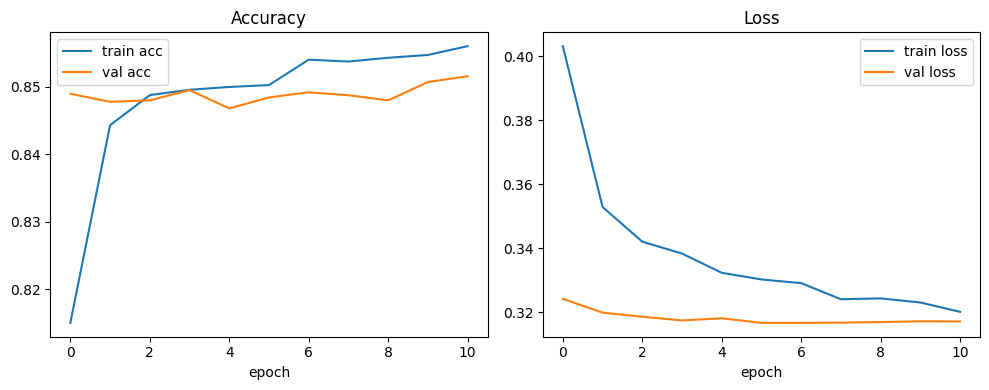

In [46]:
# Learning curves
hist = best_history.history
print("Available history keys:", hist.keys())  # quick check

# Handle both 'accuracy' / 'acc' naming
train_acc = hist.get('accuracy', hist.get('acc', []))
val_acc   = hist.get('val_accuracy', hist.get('val_acc', []))

plt.figure(figsize=(10,4))

plt.subplot(1,2,1)
plt.plot(train_acc, label='train acc')
plt.plot(val_acc,   label='val acc')
plt.title('Accuracy'); plt.xlabel('epoch'); plt.legend()

plt.subplot(1,2,2)
plt.plot(hist['loss'],      label='train loss')
plt.plot(hist['val_loss'],  label='val loss')
plt.title('Loss'); plt.xlabel('epoch'); plt.legend()

plt.tight_layout(); plt.show()

The tuned 4-layer feed-forward network reaches **≈ 0.85 validation accuracy** with dropout 0.2 and a modest architecture  ([64, 32, 16, 8]).
Learning curves overlap tightly, confirming that early stopping + dropout effectively prevent overfitting.

Key tuning take-aways

-**Compact nets beat wider ones** – doubling hidden units did not improve accuracy.

-**lr = 0.001** is consistently better than 0.01.

-**Batch 32 edges** out 64 by ~0.3 pp.

Metric highlights (val set)

-**Class ≤ 50 K**: precision 0.88, recall 0.93 – the majority class is handled well.

-**Class > 50 K**: precision 0.73, recall 0.61 – still many false negatives.
→ next step: apply class-weights or focal loss to boost minority-class recall.

Overall, the neural network delivers performance on par with Homework B1’s best models, but does so with stable training curves and no signs of over-fitting.